In [14]:
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

import os 

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

In [8]:
print("using device", device)

using device cuda


In [9]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )
        
    def forward(self, z):
        return self.net(z).view(-1, 1, 28, 28)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.view(-1, 28*28) 
        return self.net(x)
        

In [10]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002)

def get_noise(batch_size, noise_dim):
    return torch.randn(batch_size, noise_dim, device=device)

In [11]:
num_epochs = 50
noise_dim = 100
os.makedirs('mnist_results', exist_ok=True)
loss_d_list, loss_g_list = [], []

for epoch in range(num_epochs):
    total_loss_d, total_loss_g = 0, 0
    for i, (images, _) in enumerate(train_loader):
        batch_size = images.size(0)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        discriminator.zero_grad()
        outputs = discriminator(images.to(device)).view(-1, 1)
        loss_d_real = criterion(outputs, real_labels)
        loss_d_real.backward()
        
        z = get_noise(batch_size, noise_dim)
        fake_images = generator(z)
        outputs = discriminator(fake_images.detach()).view(-1, 1)
        loss_d_fake = criterion(outputs, fake_labels)
        loss_d_fake.backward()
        
        loss_d = loss_d_fake + loss_d_real
        optimizer_d.step()
        
        generator.zero_grad()
        outputs = discriminator(fake_images).view(-1, 1)
        loss_g = criterion(outputs, real_labels)
        loss_g.backward()
        optimizer_g.step()

        total_loss_d += loss_d.item()
        total_loss_g += loss_g.item()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}')
    
    total_loss_d /= len(train_loader)
    total_loss_g /= len(train_loader)
    loss_d_list.append(total_loss_d)
    loss_g_list.append(total_loss_g)
        
    fake_images = fake_images.reshape(batch_size, 1, 28, 28)
    if (epoch + 1) % 5 == 0:
        vutils.save_image(fake_images, f'mnist_results/fake_img_epoch_{epoch+1}.png', normalize=True)
        

Epoch [1/50], Step [100/938], Loss D: 0.3371, Loss G: 1.4135
Epoch [1/50], Step [200/938], Loss D: 0.0074, Loss G: 5.9558
Epoch [1/50], Step [300/938], Loss D: 0.4812, Loss G: 7.6950
Epoch [1/50], Step [400/938], Loss D: 0.0061, Loss G: 12.1229
Epoch [1/50], Step [500/938], Loss D: 0.0157, Loss G: 6.9429
Epoch [1/50], Step [600/938], Loss D: 0.0196, Loss G: 4.5171
Epoch [1/50], Step [700/938], Loss D: 0.0147, Loss G: 11.4438
Epoch [1/50], Step [800/938], Loss D: 0.1219, Loss G: 7.5192
Epoch [1/50], Step [900/938], Loss D: 0.0147, Loss G: 14.7972
Epoch [2/50], Step [100/938], Loss D: 0.2851, Loss G: 7.0651
Epoch [2/50], Step [200/938], Loss D: 0.8382, Loss G: 5.7456
Epoch [2/50], Step [300/938], Loss D: 0.4230, Loss G: 6.4126
Epoch [2/50], Step [400/938], Loss D: 0.1440, Loss G: 5.9133
Epoch [2/50], Step [500/938], Loss D: 0.2415, Loss G: 2.5467
Epoch [2/50], Step [600/938], Loss D: 0.1569, Loss G: 3.6579
Epoch [2/50], Step [700/938], Loss D: 0.0567, Loss G: 5.2704
Epoch [2/50], Step [8

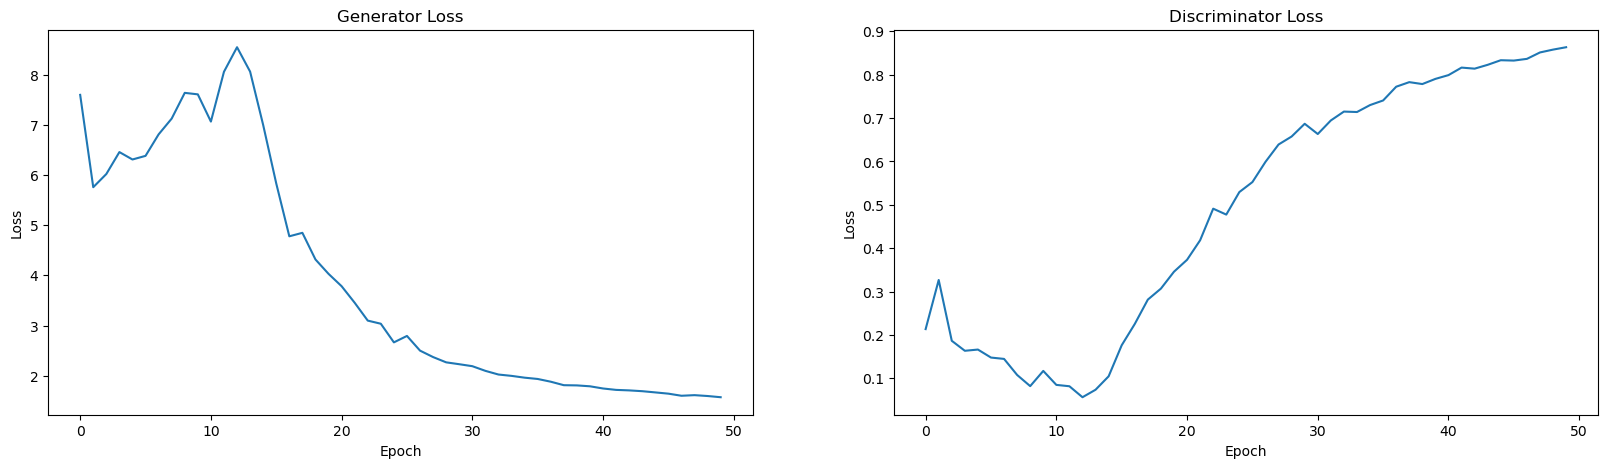

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].set_title('Generator Loss')
axs[0].plot(loss_g_list)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

axs[1].set_title('Discriminator Loss')
axs[1].plot(loss_d_list)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')

plt.show()